# Predicting Reporting Delays of Violent Sexual Crimes in LA
**Visual Data Storytelling**

**Emily Nguyen, Kaylynn Francisco-Nelson, Angela Iraya**

## Preparing Data
---

In [28]:
# Import Modules
import pandas as pd
import numpy as np

# Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

In [30]:
# Upladed dataset with merged Sexual Crimes, Hospital, and Census DATA
df = pd.read_csv("../data/SexualCrimes_Hospital_Census_Data.csv")
df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1 2,Crm Cd,Crm Cd Desc,...,Single_Parent_Rate,Uninsured_Rate,Mean_Education_Level,Mean_Education_Level_Ordinal,Median_Household_Income,Average_Household_Size,Total_Households,Total_Citizenship_Status,Total_Employment_Status,Delayed_Binary
0,202013579,08/18/2020 12:00:00 AM,08/13/2020 12:00:00 AM,100,20,Olympic,2014,2,860,BATTERY WITH SEXUAL CONTACT,...,11.671687,14.976642,no_degree,1,55492.0,2.72,1328,3639,3040,1
1,211907205,04/01/2021 12:00:00 AM,02/22/2020 12:00:00 AM,1,19,Mission,1915,1,122,"RAPE, ATTEMPTED",...,33.552632,17.484761,no_degree,1,82109.0,4.10,760,3177,2689,1
2,221908151,04/12/2022 12:00:00 AM,10/01/2020 12:00:00 AM,1,19,Mission,1988,1,821,SODOMY/SEXUAL CONTACT B/W PENIS OF ONE PERS TO...,...,29.350441,18.060436,no_degree,1,92011.0,3.40,1247,4269,3526,1
3,201904093,01/02/2020 12:00:00 AM,01/02/2020 12:00:00 AM,2025,19,Mission,1901,1,121,"RAPE, FORCIBLE",...,18.588957,16.787134,bachelors,5,113750.0,3.38,1630,5717,4456,0
4,210708216,04/29/2021 12:00:00 AM,05/01/2020 12:00:00 AM,1330,7,Wilshire,785,1,121,"RAPE, FORCIBLE",...,28.286491,16.010499,bachelors,5,75466.0,2.69,1103,3102,2534,1


In [31]:
# Creating Poverty Level Categories
df['Poverty_Level'] = pd.cut(
    df['Poverty_Rate'], 
    bins=[0, 10, 18, 26, 100],
    labels=['Low', 'Moderate', 'High', 'Very High'],
    include_lowest=True
) 

In [32]:
# Binary target variable
df['Delay_Category_Categorical'] = df['Delayed_Binary'].map({
    0: '0–1 days',
    1: '1+ days'
})

In [33]:
df.columns.unique()

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1 2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3',
       'Crm Cd 4', 'Vict Descent Full', 'Vict Age Group', 'Time_Formatted',
       'Hour', 'Time_Category', 'Date_Rptd', 'DATE_OCC', 'Year', 'Month',
       'DayOfWeek', 'Reporting_Delay', 'Delay_Category', 'LAT', 'LON',
       'Premis_Category', 'Weapon_Category', 'geometry', 'FACNAME', 'City',
       'ZIP Code', 'FAC_STATUS_TYPE_CODE', 'TRAUMA_CTR',
       'BIRTHING_FACILITY_FLAG', 'CRITICAL_ACCESS_HOSPITAL', 'LATITUDE',
       'LONGITUDE', 'COUNTY_NAME', 'distance_meters', 'hospitals_per_zip',
       'distance_miles', 'distance_category', 'index_right', 'GEOID',
       'Poverty_Rate', 'Single_Parent_Rate', 'Uninsured_Rate',
       'Mean_Education_Level', 'Mean_Education_Level_Ordinal',
       

## Baseline Random Forest Model
---

In [34]:
# target feature
target = "Delay_Category_Categorical"

# features that we want to use for prediction
numeric_features_base = ["Hour", "Year", "Part 1 2", "Rpt Dist No"]
categorical_features_base = [
    "Vict Sex", "Vict Descent Full", "Vict Age Group", "AREA NAME",
    "Premis_Category", "Crm Cd Desc", "Weapon_Category",
    "Month", "DayOfWeek", "Time_Category"
]

X_base = df[numeric_features_base + categorical_features_base]
y_base = df[target].astype(str)

**Train/Test Split**

In [35]:
# train/test split before encoding
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42, stratify=y_base
)

# encode target
le_base = LabelEncoder()
yb_train_enc = le_base.fit_transform(yb_train)
yb_test_enc = le_base.transform(yb_test)

**Preprocessing**

In [36]:
ohe_base = OneHotEncoder(handle_unknown="ignore")
preprocess_base = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features_base),
        ("cat", ohe_base, categorical_features_base),
    ]
)

**Train Baseline Random Forest**

In [37]:
pipeline_base = Pipeline([
    ("preprocess", preprocess_base),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"
    ))
])

pipeline_base.fit(Xb_train, yb_train_enc)
yb_pred = pipeline_base.predict(Xb_test)

In [38]:
# evaluation
acc_base = accuracy_score(yb_test_enc, yb_pred)
f1_base = f1_score(yb_test_enc, yb_pred, average="macro")
report_base = classification_report(yb_test_enc, yb_pred)

print("Base Dataset Performance")
print(f"Accuracy: {acc_base:.3f}, F1-macro: {f1_base:.3f}")
print(report_base)

Base Dataset Performance
Accuracy: 0.683, F1-macro: 0.683
              precision    recall  f1-score   support

           0       0.67      0.71      0.69      1235
           1       0.70      0.66      0.68      1276

    accuracy                           0.68      2511
   macro avg       0.68      0.68      0.68      2511
weighted avg       0.68      0.68      0.68      2511



# Context Improved Random Forest Model
---

In [39]:
# target feature
target = "Delay_Category_Categorical"

# features that we want to use for prediction
numeric_features = [
    "Hour", "Year", "Part 1 2", "Rpt Dist No",
    "distance_miles", "Poverty_Rate", "Single_Parent_Rate", "Uninsured_Rate", 
    "Mean_Education_Level_Ordinal", "Median_Household_Income", "Average_Household_Size",
    "Total_Households", "Total_Citizenship_Status", "Total_Employment_Status"
]

categorical_features = [
    "Vict Sex", "Vict Descent Full", "Vict Age Group", "AREA NAME",
    "Premis_Category", "Crm Cd Desc", "Weapon_Category",
    "Month", "DayOfWeek", "Time_Category",
    "COUNTY_NAME", "distance_category", "hospitals_per_zip","Mean_Education_Level"
]

X = df[numeric_features + categorical_features]
y = df[target].astype(str)

**Train/Test Split**

In [40]:
# train/test split before encoding
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# encode target
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

**Preprocessing**

In [41]:
# preprocessing: one-hot encode categorical, passthrough numerics
ohe = OneHotEncoder(handle_unknown="ignore")
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", ohe, categorical_features),
    ]
)

**Train Context-Improved Random Forest**

In [42]:
pipeline = Pipeline([
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"
    ))
])

pipeline.fit(X_train, y_train_enc)
y_pred = pipeline.predict(X_test)

In [43]:
acc = accuracy_score(y_test_enc, y_pred)
f1 = f1_score(y_test_enc, y_pred, average="macro")
report = classification_report(y_test_enc, y_pred)

print("Context-Improved Dataset Performance")
print(f"Accuracy: {acc:.3f}, F1-macro: {f1:.3f}")
print(report)

Context-Improved Dataset Performance
Accuracy: 0.679, F1-macro: 0.679
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1235
           1       0.69      0.67      0.68      1276

    accuracy                           0.68      2511
   macro avg       0.68      0.68      0.68      2511
weighted avg       0.68      0.68      0.68      2511



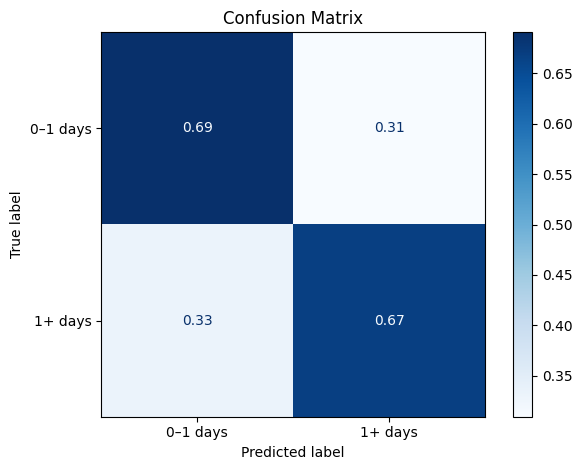

In [44]:
# Confusion Matrix for Random Forest
ConfusionMatrixDisplay.from_estimator(
    pipeline,
    X_test,
    y_test_enc,
    display_labels=le.classes_,
    cmap='Blues',
    normalize='true',
)

plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Permutation Importance

In [45]:
# Top 10 most important features from original Random Forest vs improved Random Forest

# Baseline Random Forest
base_perm = permutation_importance(
    pipeline_base, Xb_test, yb_test_enc, n_repeats=10, random_state=42
)
base_importance = pd.DataFrame({
    "feature": Xb_test.columns,
    "importance_mean": base_perm.importances_mean
}).sort_values(by="importance_mean", ascending=False).head(10)

# Context Improved Random Forest Permutation Importance
perm = permutation_importance(
    pipeline, X_test, y_test_enc, n_repeats=10, random_state=42
)

importance_perm = pd.DataFrame({
    "feature": X_test.columns,
    "importance_mean": perm.importances_mean
}).sort_values(by="importance_mean", ascending=False).head(10)

# Combine for comparison
comparison_df = pd.DataFrame({
    "Original Top 10 Features": base_importance["feature"].values,
    "Original Importance": base_importance["importance_mean"].values,
    "Improved Top 10 Features": importance_perm["feature"].values,
    "Improved Importance": importance_perm["importance_mean"].values
})

print("\nFeature Importance Comparison (Top 10)\n")
print(comparison_df.to_string(index=False))


Feature Importance Comparison (Top 10)

Original Top 10 Features  Original Importance Improved Top 10 Features  Improved Importance
          Vict Age Group             0.053684           Vict Age Group             0.051653
         Premis_Category             0.045759          Premis_Category             0.042573
             Crm Cd Desc             0.023696              Crm Cd Desc             0.017642
                    Hour             0.018319                     Hour             0.006213
               AREA NAME             0.010633            Time_Category             0.006093
       Vict Descent Full             0.008045                     Year             0.003744
           Time_Category             0.007368                 Part 1 2             0.001752
                    Year             0.006969        hospitals_per_zip             0.000319
               DayOfWeek             0.005337           distance_miles             0.000239
             Rpt Dist No             0.

### SHAP

In [46]:
import shap

# Get preprocessed data for SHAP

preprocessed_data = preprocess.transform(X_test)
feature_names = (numeric_features + 
                 list(preprocess.named_transformers_['cat'].get_feature_names_out(categorical_features)))

# Convert to dense array
if hasattr(preprocessed_data, 'toarray'):
    preprocessed_dense = preprocessed_data.toarray()
else:
    preprocessed_dense = preprocessed_data

# Use only 500 samples for SHAP (faster)
sample_size = min(500, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)

X_test_processed = pd.DataFrame(preprocessed_dense[sample_indices], 
                               columns=feature_names, 
                               index=X_test.index[sample_indices])

print(f"SHAP data shape: {X_test_processed.shape}")
print(f"Using {sample_size} samples for faster computation")

# Initialize SHAP explainer
explainer = shap.TreeExplainer(pipeline.named_steps['clf'])

# Calculate SHAP values for the sample
shap_values = explainer.shap_values(X_test_processed)

# Handle binary classification
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_delayed = shap_values[1]  # Use class 1 (Delayed)
else:
    shap_values_delayed = shap_values

SHAP data shape: (500, 110)
Using 500 samples for faster computation


In [47]:
# Handle binary classification
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_delayed = shap_values[1]  # Use class 1 (Delayed)
else:
    shap_values_delayed = shap_values

print(f"shap_values_delayed shape: {shap_values_delayed.shape}")

if shap_values_delayed.ndim == 3:
    # Extract SHAP values for class 1 (delayed) across all samples and features
    shap_values_class1 = shap_values_delayed[:, :, 1]  # Shape: (500, 85)
    
    
    # Calculate mean absolute SHAP across samples
    mean_abs_shap = np.abs(shap_values_class1).mean(axis=0) 
else:

    mean_abs_shap = np.abs(shap_values_delayed).mean(axis=0)

# Ensure both arrays have the same length
min_length = min(len(feature_names), len(mean_abs_shap))
feature_names_trimmed = feature_names[:min_length]
mean_abs_shap_trimmed = mean_abs_shap[:min_length]

shap_values_delayed shape: (500, 110, 2)


In [63]:
# Top 10 Features from SHAP Analysis
shap_importance = pd.DataFrame({
    'feature': feature_names_trimmed,
    'importance': mean_abs_shap_trimmed
}).sort_values('importance', ascending=False).head(15)

print(f"Top features from SHAP analysis:")
print(shap_importance[['feature', 'importance']].to_string(index=False))

Top features from SHAP analysis:
                                                             feature  importance
                                         Premis_Category_Residential    0.041029
                                  Vict Age Group_Adolescents (13-17)    0.040573
                                      Premis_Category_Public Outdoor    0.029040
                                       Vict Age Group_Adults (25-49)    0.024195
                             Crm Cd Desc_BATTERY WITH SEXUAL CONTACT    0.022169
Crm Cd Desc_SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ    0.017907
                                                                Hour    0.016453
                                      Vict Age Group_Children (0-12)    0.015553
                                                         Rpt Dist No    0.012361
                                 Vict Age Group_Young Adults (18-24)    0.011510
                                             Median_Household_Income    0.00

# Visualizations
---

In [53]:
# Styling: consistent purple theme
PURPLES = ["#f3e8ff", "#e9d5ff", "#d8b4fe", "#c084fc", "#a855f7", "#7c2dff"]  # light -> strong
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["font.size"] = 10
plt.rcParams["axes.titlepad"] = 12

def save_fig(fig, filename, dpi=200):
    outdir = "dashboard_figures"
    os.makedirs(outdir, exist_ok=True)
    path = os.path.join(outdir, filename)
    fig.savefig(path, dpi=dpi)
    print("Saved:", path)


### Model & Performance Visuals

**Model Performance Comparison Bar Chart - Accuracy & F1**

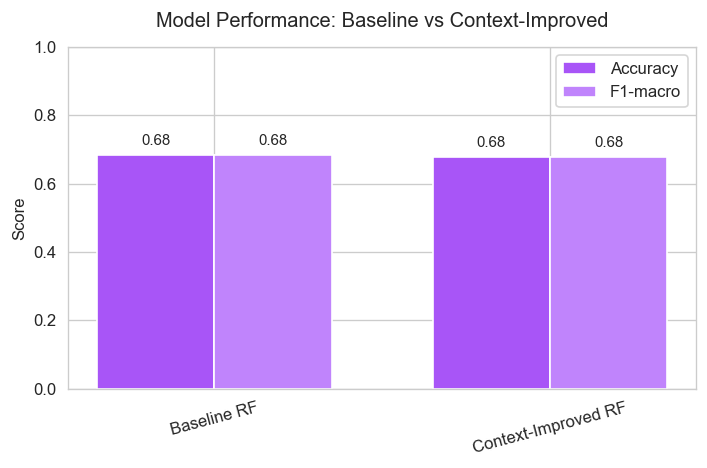

Caption: Comparison of baseline and context-enhanced Random Forests showing Accuracy and F1-macro. The context-enhanced model incorporates neighborhood/hospital/census features; scores are similar, indicating modest improvement from added context.


In [ ]:
# Model Comparison (Accuracy & F1)

# baseline predictions already computed earlier as yb_pred / yb_test_enc
acc_base = accuracy_score(yb_test_enc, pipeline_base.predict(Xb_test))
f1_base = f1_score(yb_test_enc, pipeline_base.predict(Xb_test), average="macro")

acc_improved = accuracy_score(y_test_enc, pipeline.predict(X_test))
f1_improved = f1_score(y_test_enc, pipeline.predict(X_test), average="macro")

metrics_df = {
    "Model": ["Baseline RF", "Context-Improved RF"],
    "Accuracy": [acc_base, acc_improved],
    "F1-macro": [f1_base, f1_improved]
}

# Plot grouped bar chart
fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(metrics_df["Model"]))
width = 0.35

ax.bar(x - width/2, metrics_df["Accuracy"], width, label="Accuracy", color=PURPLES[-2])
ax.bar(x + width/2, metrics_df["F1-macro"], width, label="F1-macro", color=PURPLES[-3])

ax.set_xticks(x)
ax.set_xticklabels(metrics_df["Model"], rotation=15)
ax.set_ylim(0,1)
ax.set_ylabel("Score")
ax.set_title("Model Performance: Baseline vs Context-Improved")
ax.legend()
for i, (a, b) in enumerate(zip(metrics_df["Accuracy"], metrics_df["F1-macro"])):
    ax.text(i - width/2, a + 0.02, f"{a:.2f}", ha="center", va="bottom", fontsize=9)
    ax.text(i + width/2, b + 0.02, f"{b:.2f}", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# Caption for PDF (copy-paste)
print("Caption: Comparison of baseline and context-enhanced Random Forests showing Accuracy and F1-macro. The context-enhanced model incorporates neighborhood/hospital/census features; scores are similar, indicating modest improvement from added context.")


**Baseline vs Improved Bar Chart - Permutation Importances**

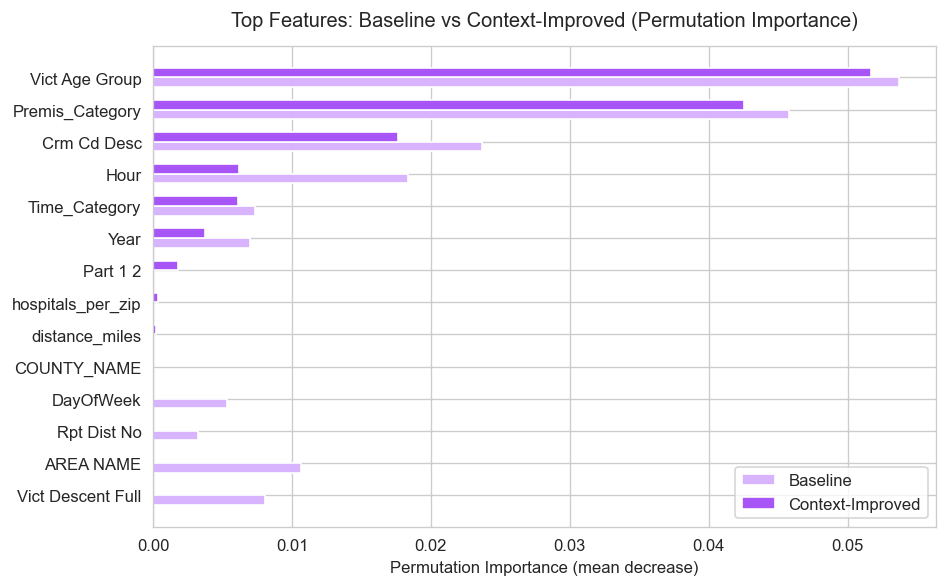

Caption: Permutation importance (top features) comparing the baseline and context-improved models. Note which contextual features appear (e.g., income, hospitals per ZIP) and how importance shifts when context is included.


In [56]:
# Permutation Importance Comparison (Top 10)
base_perm = permutation_importance(pipeline_base, Xb_test, yb_test_enc, n_repeats=10, random_state=42, n_jobs=-1)
base_importance = pd.DataFrame({"feature": Xb_test.columns, "importance_mean": base_perm.importances_mean}).sort_values("importance_mean", ascending=False).head(10)

perm = permutation_importance(pipeline, X_test, y_test_enc, n_repeats=10, random_state=42, n_jobs=-1)
importance_perm = pd.DataFrame({"feature": X_test.columns, "importance_mean": perm.importances_mean}).sort_values("importance_mean", ascending=False).head(10)

# Build combined DataFrame for plotting
left = base_importance.set_index("feature").importance_mean
right = importance_perm.set_index("feature").importance_mean
combined = pd.concat([left, right], axis=1).fillna(0)
combined.columns = ["Baseline", "Context-Improved"]
combined = combined.sort_values("Context-Improved", ascending=True)  # for horizontal bar order

# Plot horizontal grouped bars
fig, ax = plt.subplots(figsize=(8,5))
y_pos = np.arange(len(combined))
ax.barh(y_pos - 0.15, combined["Baseline"], height=0.3, label="Baseline", color=PURPLES[-4])
ax.barh(y_pos + 0.15, combined["Context-Improved"], height=0.3, label="Context-Improved", color=PURPLES[-2])

ax.set_yticks(y_pos)
ax.set_yticklabels(combined.index)
ax.set_xlabel("Permutation Importance (mean decrease)")
ax.set_title("Top Features: Baseline vs Context-Improved (Permutation Importance)")
ax.legend()
plt.tight_layout()
plt.show()

# Caption
print("Caption: Permutation importance (top features) comparing the baseline and context-improved models. Note which contextual features appear (e.g., income, hospitals per ZIP) and how importance shifts when context is included.")


**SHAP Analysis**

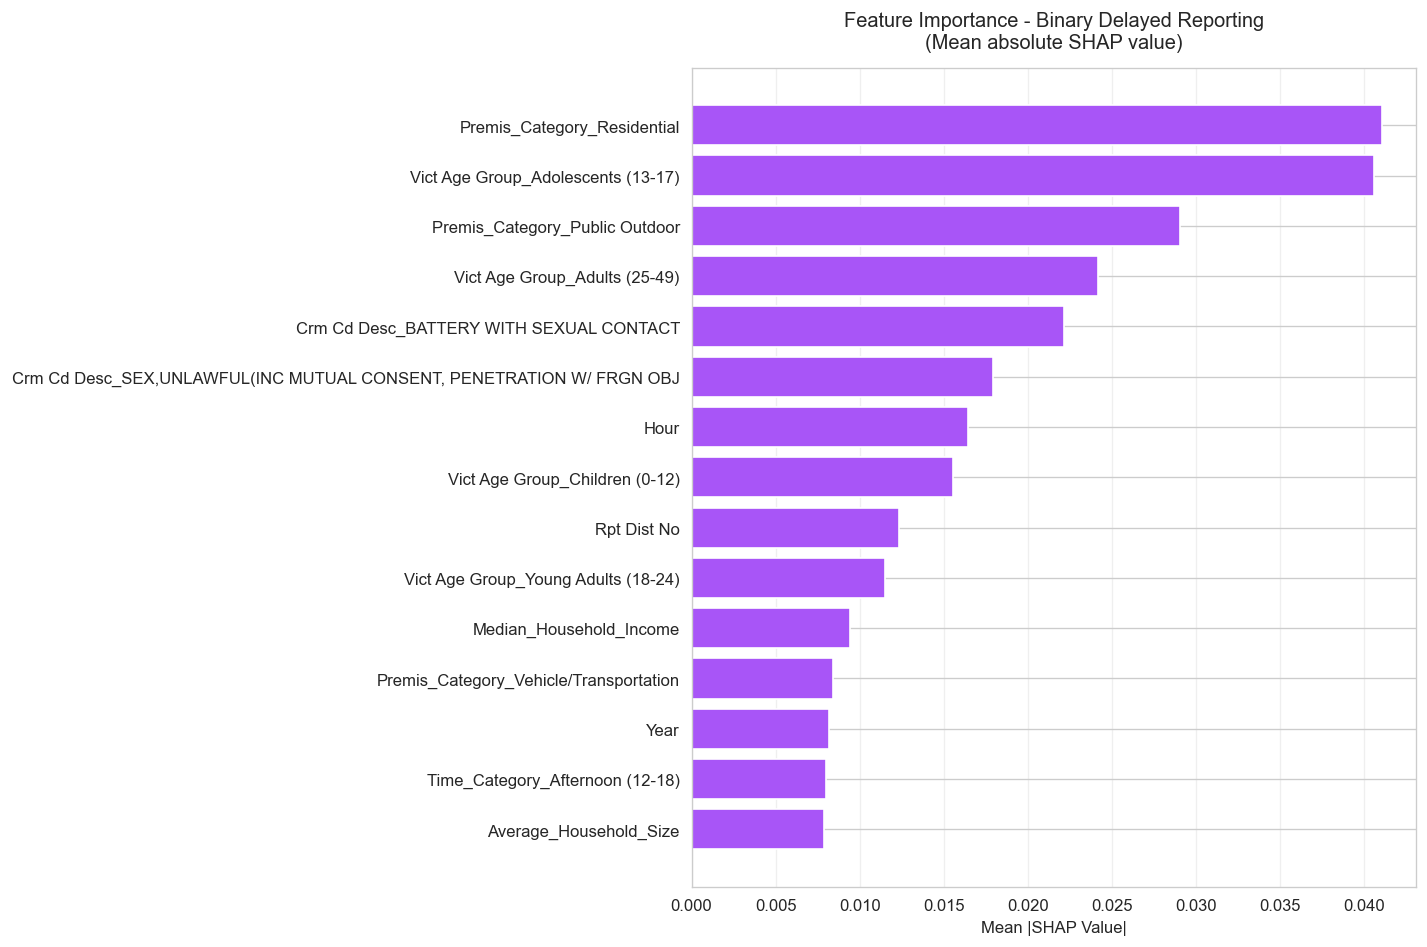

Caption: SHAP feature importance (mean absolute SHAP) showing which features push predictions toward 'Delayed'. The bar plot highlights which features (and contextual features) most influence the model's delayed prediction.


In [70]:
# Sort by importance (descending)
shap_sorted = shap_importance.sort_values('importance', ascending=True)

# SHAP summary plot (uses shap_values computed earlier)
plt.figure(figsize=(12, 8))
y_pos = np.arange(len(shap_sorted))
plt.barh(y_pos, shap_sorted['importance'], color=PURPLES[-2])
plt.yticks(y_pos, shap_sorted['feature'])
plt.xlabel('Mean |SHAP Value|')
plt.title(f'Feature Importance - Binary Delayed Reporting\n(Mean absolute SHAP value)')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Caption
print("Caption: SHAP feature importance (mean absolute SHAP) showing which features push predictions toward 'Delayed'. The bar plot highlights which features (and contextual features) most influence the model's delayed prediction.")


### Contextual Feature Visuals

**Incident Locations by Poverty Rate**

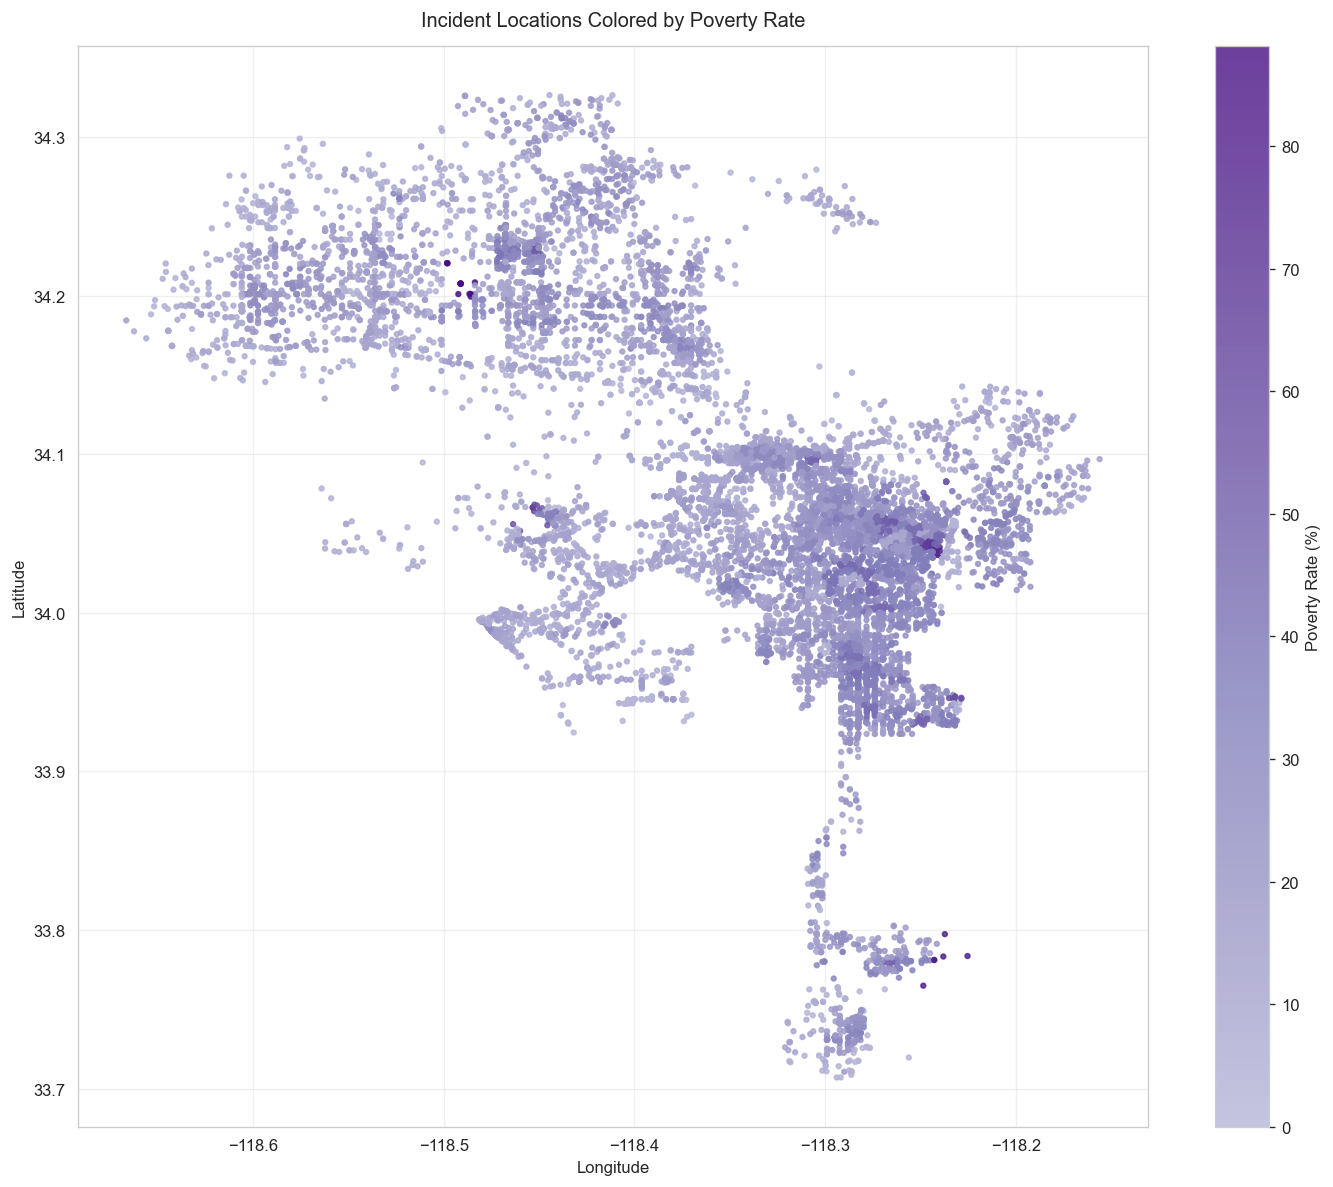

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

import matplotlib.colors as colors
def truncate_colormap(cmap_name, min_val=0.3, max_val=1.0):
    """Return a truncated colormap from min_val to max_val."""
    cmap = plt.get_cmap(cmap_name)
    new_cmap = colors.LinearSegmentedColormap.from_list(
        f"{cmap_name}_trunc",
        cmap(np.linspace(min_val, max_val, 256))
    )
    return new_cmap

# Make Purples start darker
dark_purples = truncate_colormap("Purples", 0.4, 0.95)


# Ensure lat/lon exist
map_df = df.dropna(subset=["LAT", "LON", "Poverty_Rate"]).copy()
map_df["LAT"] = pd.to_numeric(map_df["LAT"], errors="coerce")
map_df["LON"] = pd.to_numeric(map_df["LON"], errors="coerce")
map_df = map_df.dropna(subset=["LAT", "LON"])

# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(map_df["LON"], map_df["LAT"])]
gdf = gpd.GeoDataFrame(map_df, geometry=geometry, crs="EPSG:4326")

# Plot
plt.figure(figsize=(12, 10))

scatter = plt.scatter(
    gdf.geometry.x,
    gdf.geometry.y,
    c=gdf["Poverty_Rate"],
    cmap=dark_purples,   # <-- use darker purples
    s=8,
    alpha=0.8
)

cbar = plt.colorbar(scatter)
cbar.set_label("Poverty Rate (%)")

plt.title("Incident Locations Colored by Poverty Rate")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

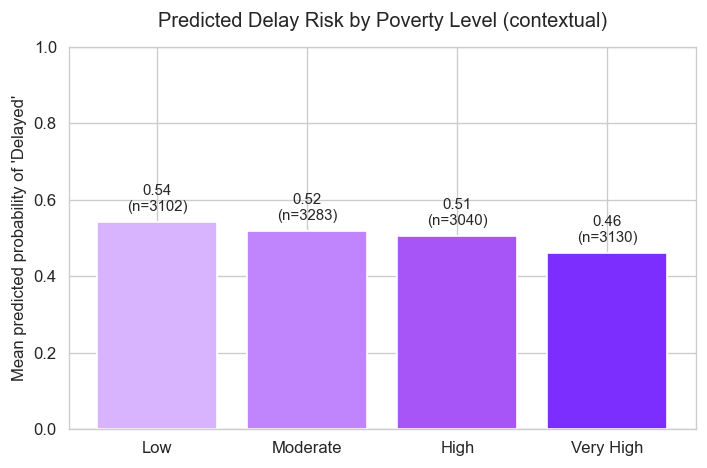

Caption: Mean predicted probability of reporting delay (1+ days) stratified by neighborhood Poverty_Level. Bars show how predicted risk varies across poverty bins and sample counts (n).


In [74]:
# Binned bar chart — mean predicted probability of 'Delayed' by Poverty_Level

# Ensure Poverty_Level exists; you created it earlier as categorical
df["Poverty_Level"] = df["Poverty_Level"].astype(str)

# Get predicted probabilities for the improved pipeline (class for '1+ days')
proba = pipeline.predict_proba(X)  # uses same X used for training/test earlier
# determine which column corresponds to delayed class in label encoder
delayed_class_index = list(le.classes_).index("1+ days") if "1+ days" in list(le.classes_) else 1
pred_probs = proba[:, delayed_class_index]

# Attach to original dataframe (aligning indices)
pred_proba_series = pd.Series(pred_probs, index=X.index, name="pred_proba_delayed")
df_probs = pd.concat([df, pred_proba_series], axis=1).dropna(subset=["pred_proba_delayed", "Poverty_Level"])

# Group by Poverty_Level and compute mean predicted probability
grouped = df_probs.groupby("Poverty_Level")["pred_proba_delayed"].agg(["mean", "count"]).reindex(["Low", "Moderate", "High", "Very High"])

fig, ax = plt.subplots(figsize=(6,4))
bars = ax.bar(grouped.index, grouped["mean"], color=[PURPLES[2], PURPLES[3], PURPLES[4], PURPLES[5]])
ax.set_ylim(0,1)
ax.set_ylabel("Mean predicted probability of 'Delayed'")
ax.set_title("Predicted Delay Risk by Poverty Level (contextual)")
for i, v in enumerate(grouped["mean"]):
    ax.text(i, v + 0.02, f"{v:.2f}\n(n={int(grouped['count'].iloc[i])})", ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# Caption
print("Caption: Mean predicted probability of reporting delay (1+ days) stratified by neighborhood Poverty_Level. Bars show how predicted risk varies across poverty bins and sample counts (n).")


C:\Users\brenn\AppData\Local\Temp\ipykernel_3580\2299873760.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_df = df.groupby('distance_bin')['Delayed_Binary'].mean()


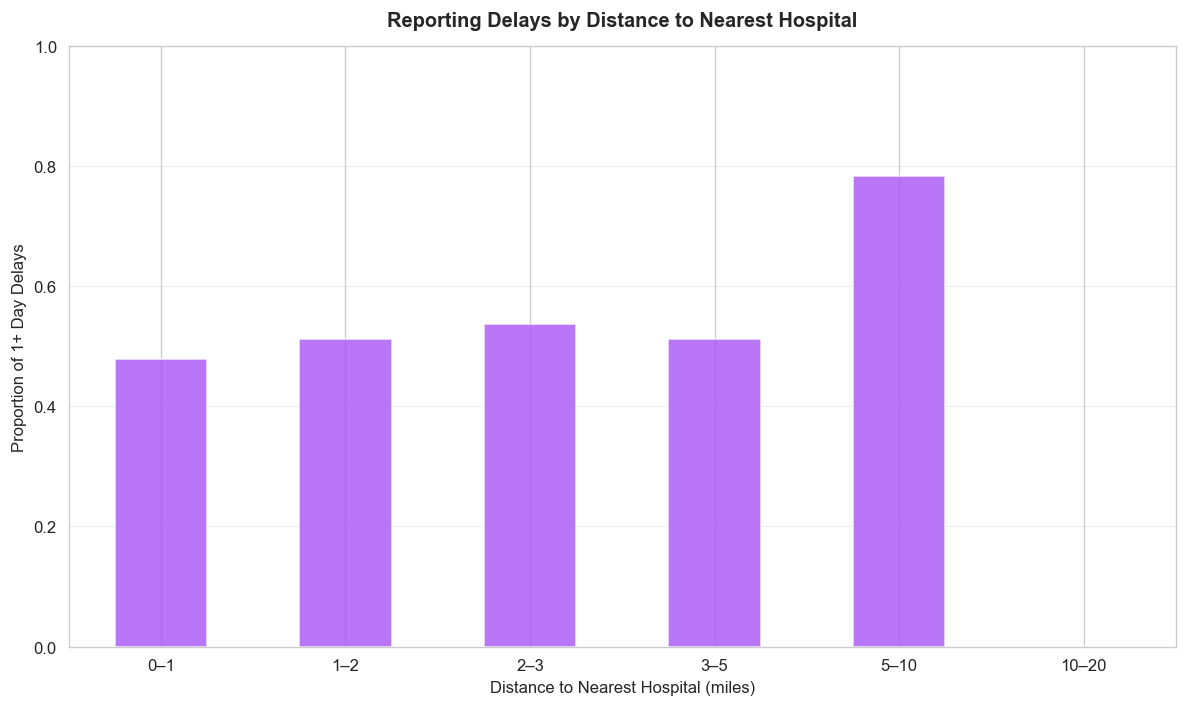

In [ ]:
# Define bins and labels
bins = [0, 1, 2, 3, 5, 10, 20]
labels = ['0–1', '1–2', '2–3', '3–5', '5–10', '10–20']

# Create a binned column with labels
df['distance_bin'] = pd.cut(df['distance_miles'], bins=bins, labels=labels, include_lowest=True)

# Calculate proportion delayed in each bin
prop_df = df.groupby('distance_bin')['Delayed_Binary'].mean()

# Plot
plt.figure(figsize=(10, 6))
prop_df.plot(kind='bar', color=PURPLES[-2], alpha=0.8)

plt.ylabel('Proportion of 1+ Day Delays')
plt.xlabel('Distance to Nearest Hospital (miles)')
plt.title('Reporting Delays by Distance to Nearest Hospital', fontweight='bold')
plt.xticks(rotation=0)
plt.ylim(0, 1)  # makes the proportion scale clear
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Fairness & Equity Evalutation Visuals

In [87]:
# Attatch predicted values and true labels for analysis
fairness_df = X_test.copy()
fairness_df["true_label"] = y_test_enc
fairness_df["pred_label"] = y_pred
fairness_df["Vict Age Group"] = X_test["Vict Age Group"]
fairness_df["AREA NAME"] = X_test["AREA NAME"]
fairness_df["Poverty_Rate"] = X_test["Poverty_Rate"]

fairness_df.head()

# Function to compute metrics by group
def compute_group_metrics(df, group_col):
    group_metrics = []
    for group, data in df.groupby(group_col):
        acc = accuracy_score(data["true_label"], data["pred_label"])
        prec = precision_score(data["true_label"], data["pred_label"], average="macro", zero_division=0)
        rec = recall_score(data["true_label"], data["pred_label"], average="macro", zero_division=0)
        f1 = f1_score(data["true_label"], data["pred_label"], average="macro", zero_division=0)

        # Compute confusion matrix for FPR/FNR
        tn, fp, fn, tp = confusion_matrix(data["true_label"], data["pred_label"], labels=[0,1]).ravel()
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

        group_metrics.append({
            group_col: group,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1": f1,
            'FPR': fpr,
            'FNR': fnr
        })
    return pd.DataFrame(group_metrics).sort_values("Accuracy", ascending=False)

In [88]:
# Compute metrics by Victim Age Group
metrics_by_age = compute_group_metrics(fairness_df, "Vict Age Group")
metrics_by_age

,Vict Age Group,Accuracy,Precision,Recall,F1,FPR,FNR
2,Children (0-12),0.750000,0.663854,0.577926,0.579861,0.782609,0.061538
0,Adolescents (13-17),0.746006,0.734940,0.647012,0.656915,0.637255,0.068720
4,Young Adults (18-24),0.651261,0.636304,0.624583,0.625871,0.227758,0.523077
3,Older Adults (50+),0.650442,0.654525,0.637926,0.634641,0.204918,0.519231
1,Adults (25-49),0.644489,0.633813,0.619129,0.618886,0.218213,0.543529


In [89]:
# Compute metrics by Area of Crime Occurence
metrics_by_area = compute_group_metrics(fairness_df, "AREA NAME")
metrics_by_area.head(10)  # Show top 10 areas

,AREA NAME,Accuracy,Precision,Recall,F1,FPR,FNR
14,Southeast,0.760000,0.754637,0.751834,0.753030,0.194444,0.301887
6,Hollywood,0.752941,0.739274,0.744322,0.741342,0.219048,0.292308
10,Northeast,0.747368,0.731638,0.731638,0.731638,0.333333,0.203390
3,Foothill,0.742268,0.727252,0.729505,0.728291,0.324324,0.216667
4,Harbor,0.704762,0.704793,0.704644,0.704655,0.307692,0.283019
11,Olympic,0.700000,0.706473,0.711429,0.699248,0.220000,0.357143
5,Hollenbeck,0.691176,0.691176,0.692677,0.690574,0.290323,0.324324
8,N Hollywood,0.685185,0.679365,0.677363,0.678121,0.382979,0.262295
7,Mission,0.684211,0.640568,0.618462,0.622794,0.589744,0.173333
0,77th Street,0.681159,0.676923,0.676087,0.676440,0.278261,0.369565


In [91]:
fairness_df['Poverty_Level'] = pd.cut(
    fairness_df['Poverty_Rate'], 
    bins=[0, 10, 18, 26, 100],
    labels=['Low', 'Moderate', 'High', 'Very High'],
    include_lowest=True
) 

# Compute metrics by Poverty Level
metrics_by_poverty = compute_group_metrics(fairness_df, "Poverty_Level")
metrics_by_poverty.head()

C:\Users\brenn\AppData\Local\Temp\ipykernel_3580\2008528305.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for group, data in df.groupby(group_col):


,Poverty_Level,Accuracy,Precision,Recall,F1,FPR,FNR
0,Low,0.702362,0.701011,0.695527,0.696534,0.380623,0.228324
3,Very High,0.700321,0.702968,0.690374,0.690889,0.194690,0.424561
2,High,0.678694,0.678492,0.678384,0.678420,0.308725,0.334507
1,Moderate,0.637313,0.636186,0.636864,0.636204,0.368932,0.357341


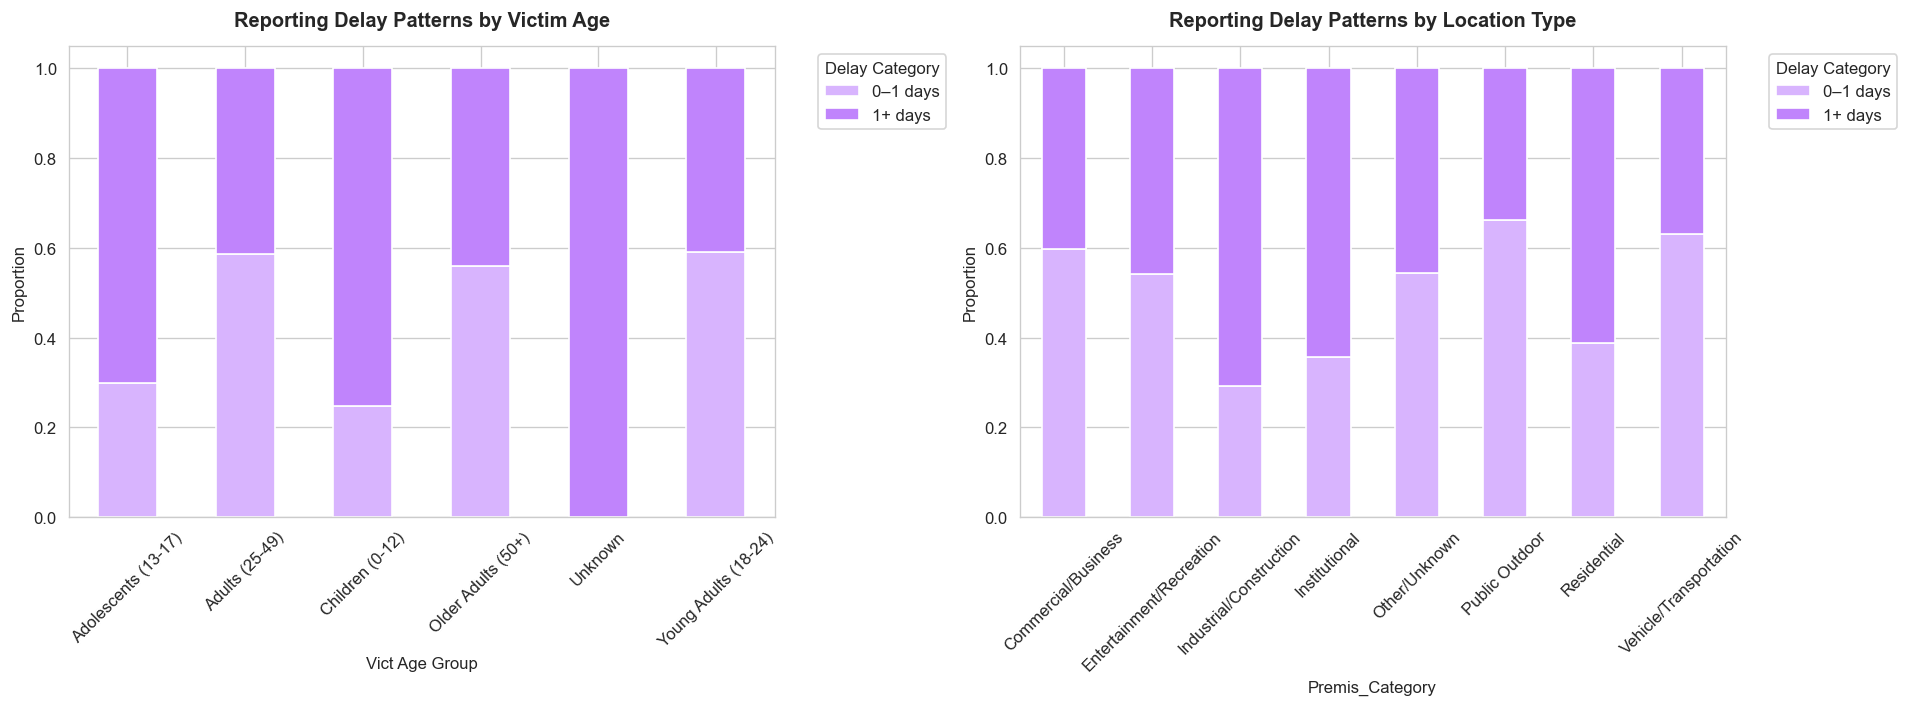

In [92]:
# Cell X: Delay Patterns by Age and Premise, using darker PURPLES
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Use only the darker PURPLES (skip the lightest 2)
stack_colors = PURPLES[2:]  # adjust indices if needed

# 1️⃣ Victim Age Group by Delay Category
age_delay_cross = pd.crosstab(df['Vict Age Group'], df['Delay_Category_Categorical'], normalize='index')
age_delay_cross.plot(kind='bar', stacked=True, ax=ax1, color=stack_colors)
ax1.set_title('Reporting Delay Patterns by Victim Age', fontweight='bold')
ax1.set_ylabel('Proportion')
ax1.legend(title='Delay Category', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# 2️⃣ Premise Type by Delay Category
premise_delay_cross = pd.crosstab(df['Premis_Category'], df['Delay_Category_Categorical'], normalize='index')
premise_delay_cross.head(8).plot(kind='bar', stacked=True, ax=ax2, color=stack_colors)
ax2.set_title('Reporting Delay Patterns by Location Type', fontweight='bold')
ax2.set_ylabel('Proportion')
ax2.legend(title='Delay Category', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


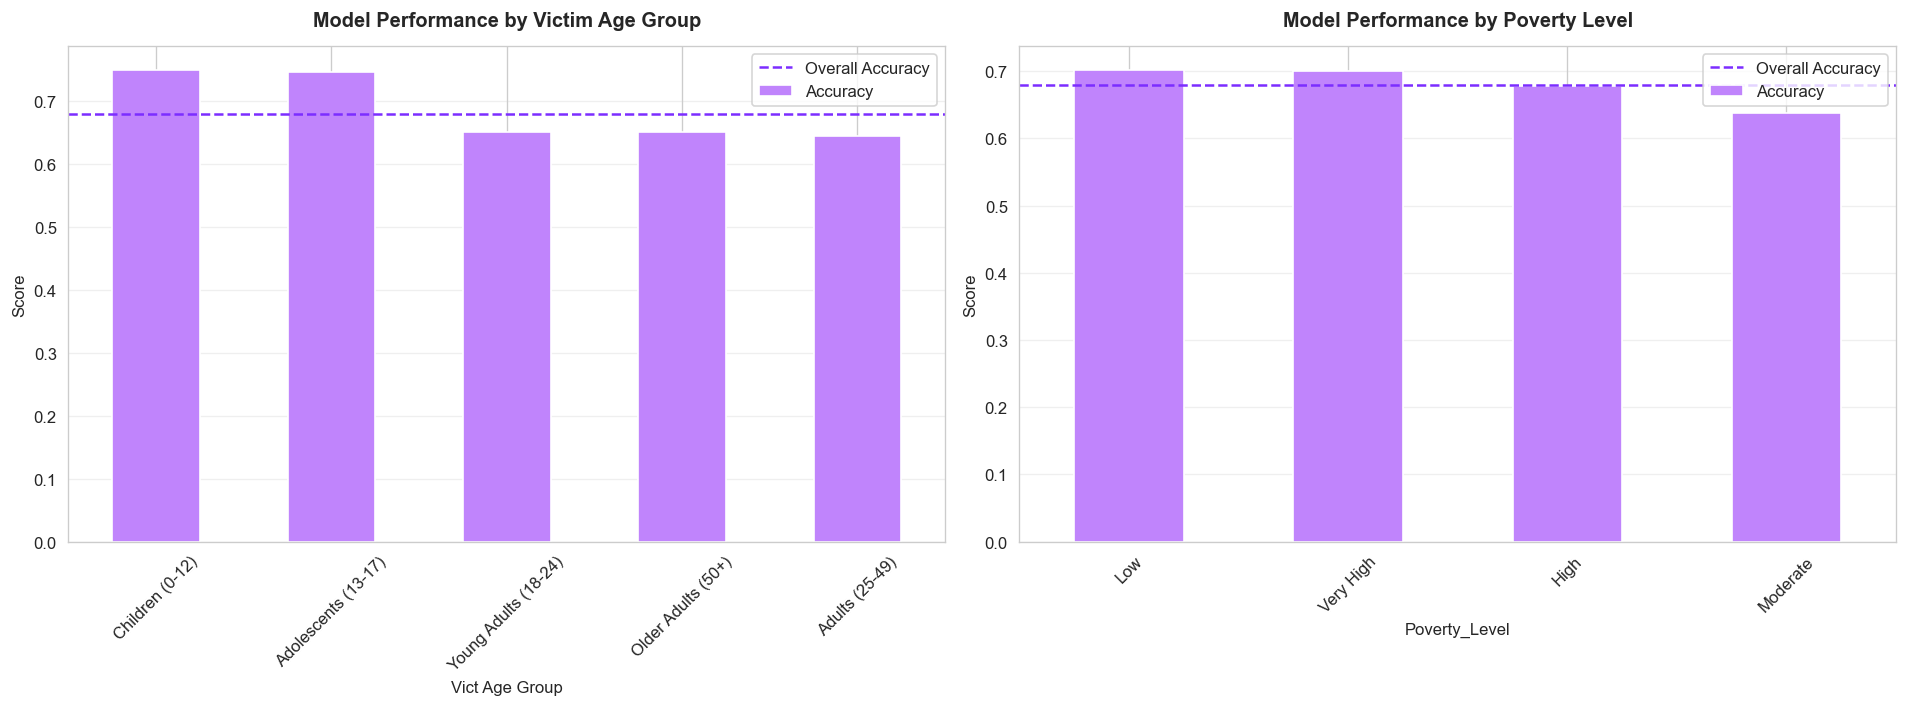

In [ ]:
# Cell X: Model Accuracy by Age Group and Poverty Level
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Use darker PURPLES for bars
bar_colors = PURPLES[-3:]  # last two colors for better contrast

# 1️⃣ Performance by Age Group
metrics_by_age.plot(
    x='Vict Age Group', 
    y=['Accuracy'], 
    kind='bar', 
    ax=ax1, 
    color=bar_colors
)
ax1.axhline(y=acc, color=PURPLES[-1], linestyle='--', label=f'Overall Accuracy')
ax1.set_title('Model Accuracy by Victim Age Group', fontweight='bold')
ax1.set_ylabel('Score')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# 2️⃣ Performance by Poverty Level
metrics_by_poverty.plot(
    x='Poverty_Level', 
    y=['Accuracy'], 
    kind='bar', 
    ax=ax2, 
    color=bar_colors
)
ax2.axhline(y=acc, color=PURPLES[-1], linestyle='--', label=f'Overall Accuracy')
ax2.set_title('Model Accuracy by Poverty Level', fontweight='bold')
ax2.set_ylabel('Score')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

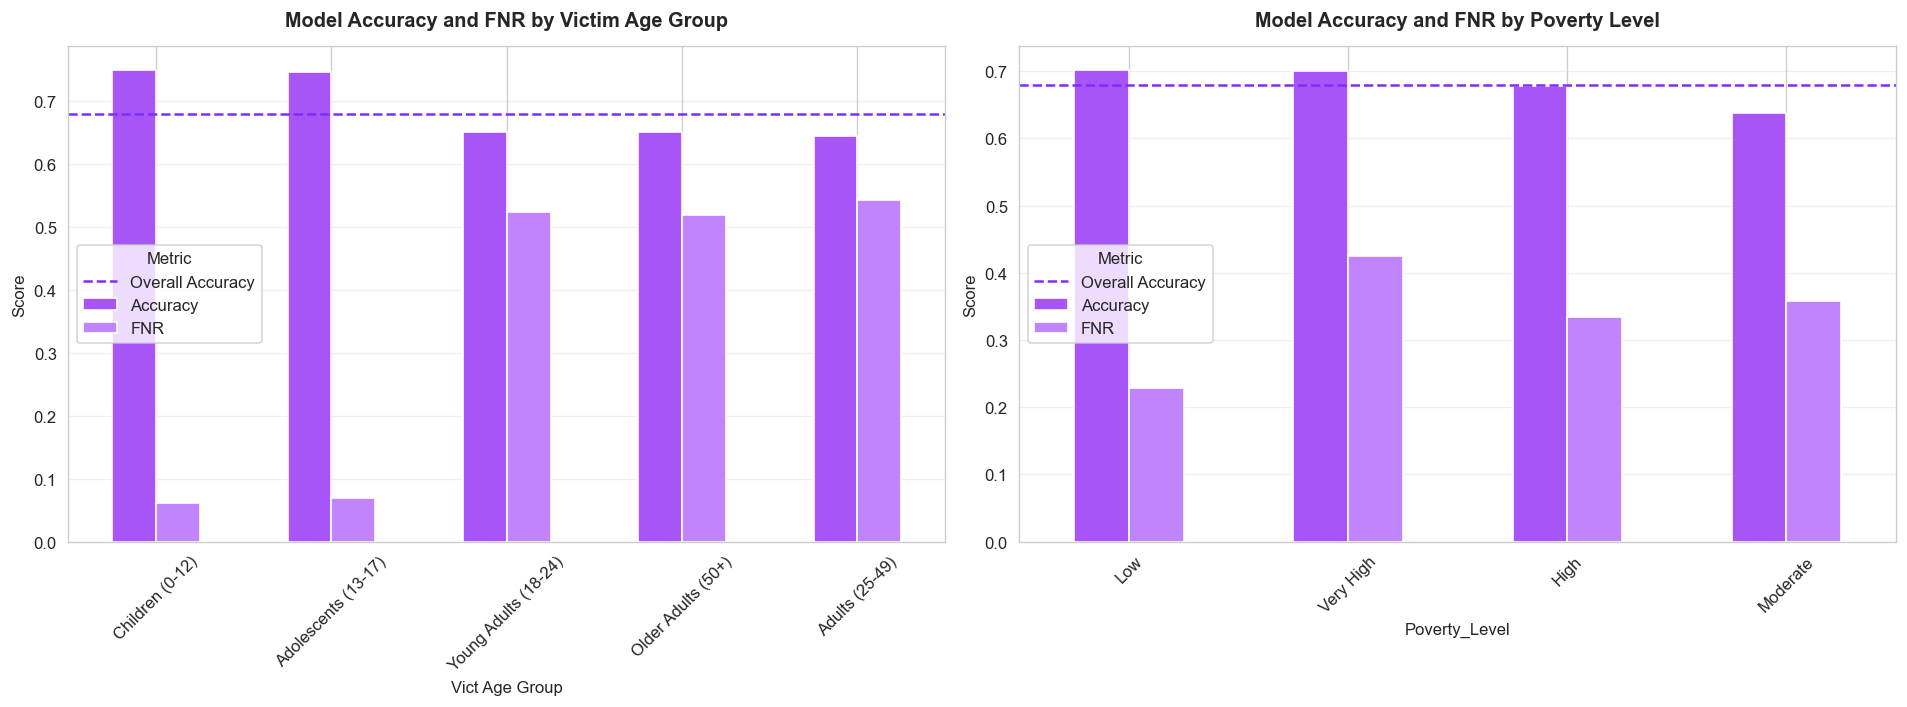

In [ ]:
# Cell X: Model Accuracy and FNR by Age Group and Poverty Level
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Two darker PURPLES for Accuracy vs FNR
metric_colors = [PURPLES[-2], PURPLES[-3]]  # Accuracy, FNR

# 1️⃣ Performance by Age Group
metrics_by_age.plot(
    x='Vict Age Group', 
    y=['Accuracy', 'FNR'],  # include FNR
    kind='bar', 
    ax=ax1, 
    color=metric_colors
)
ax1.axhline(y=acc, color=PURPLES[-1], linestyle='--', label='Overall Accuracy')
ax1.set_title('Model Accuracy and FNR by Victim Age Group', fontweight='bold')
ax1.set_ylabel('Score')
ax1.legend(title='Metric')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# 2️⃣ Performance by Poverty Level
metrics_by_poverty.plot(
    x='Poverty_Level', 
    y=['Accuracy', 'FNR'],  # include FNR
    kind='bar', 
    ax=ax2, 
    color=metric_colors
)
ax2.axhline(y=acc, color=PURPLES[-1], linestyle='--', label='Overall Accuracy')
ax2.set_title('Model Accuracy and FNR by Poverty Level', fontweight='bold')
ax2.set_ylabel('Score')
ax2.legend(title='Metric')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

C:\Users\brenn\AppData\Local\Temp\ipykernel_3580\3888205243.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\brenn\AppData\Local\Temp\ipykernel_3580\3888205243.py:4: UserWarning: 
The palette list has fewer values (6) than needed (21) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


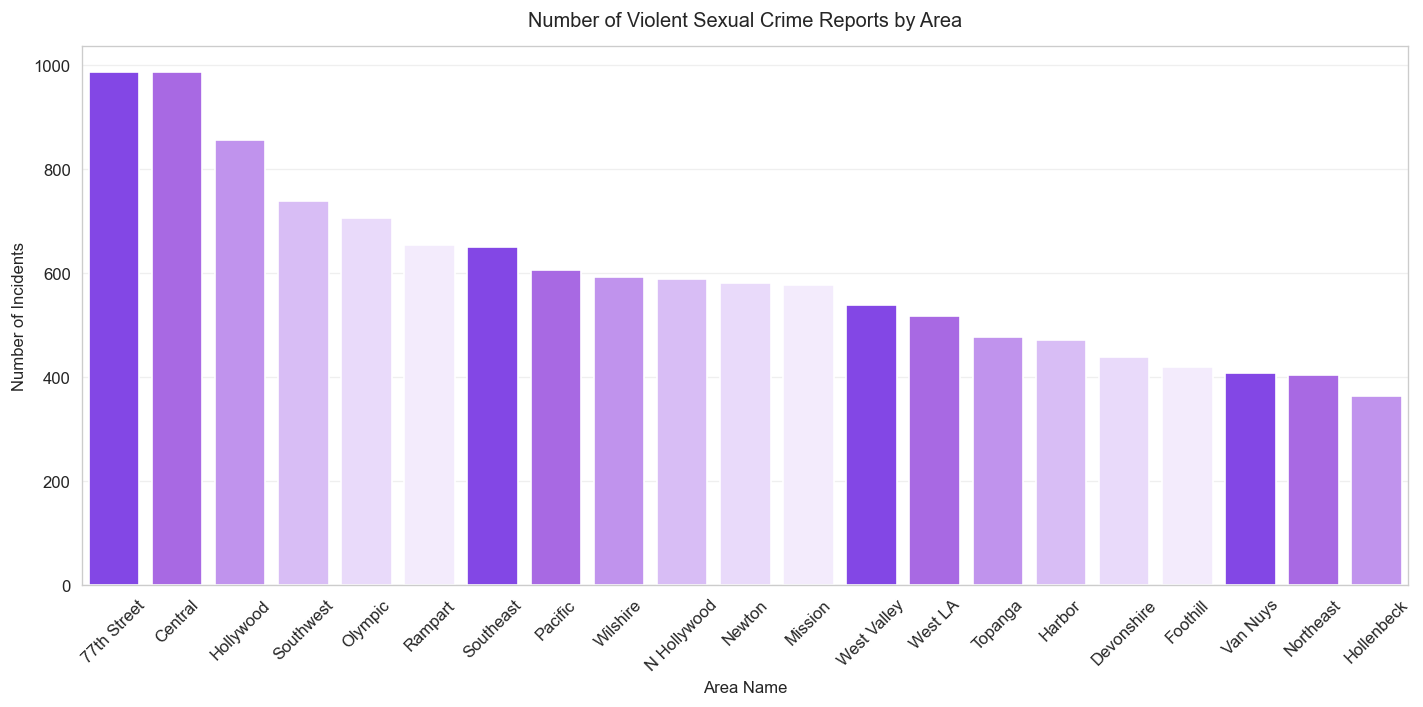

In [79]:
# Cell X: Heatmap by AREA
area_counts = df['AREA NAME'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(
    x=area_counts.index, 
    y=area_counts.values, 
    palette=PURPLES[::-1]
)
plt.xticks(rotation=45)
plt.ylabel("Number of Incidents")
plt.xlabel("Area Name")
plt.title("Number of Violent Sexual Crime Reports by Area")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
